In [1]:
from lorenz_setup import simulate_lorenz

In [2]:
import matplotlib.pyplot as plt

In [3]:
import torch
import numpy as np

In [4]:
from lorenz_settings import (
    N_UNITS,
    MAX_DELAY,
    ALPHA,
    BETA,
    GAMMA,
    DT,
    LMBDA1,
    LMBDA2,
    LMBDA3,
    LMBDA4,
    U_FACTOR,
    W_FACTOR,
)

In [5]:
def preprocess_X(X):
    # normalize features to mean 0 and variance 1
    # return (X - X.mean(axis=0)) / np.std(X, axis=0)
    # normalize features to range [0, 1]
    return (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

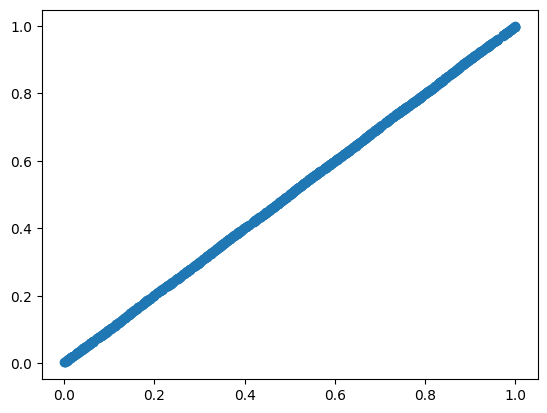

In [6]:
def generate_tuning_curves(scalars, dimensions):
    """
    Generate tuning curves as Gaussian curves centered around scalar values.

    Args:
    scalars (ndarray): Array of scalar values between 0 and 1.
    dimensions (int): Number of dimensions in the array.
    width (float): Width of the Gaussian curve.

    Returns:
    tuning_curves (ndarray): Array of N-dimensional arrays representing tuning curves.
    """
    width = 1 / dimensions
    positions = np.linspace(-3 * width, 1 + 3 * width, dimensions)
    tuning_curves = np.exp(
        -((positions[np.newaxis, :] - scalars[:, np.newaxis]) ** 2) / (2 * width**2)
    )
    return tuning_curves


def estimate_scalars_from_tuning_curves(tuning_curves):
    """
    Estimate scalar values from arrays of N-dimensional tuning curves.
    
    Args:
    tuning_curves (ndarray): Array of N-dimensional arrays representing tuning curves.
    width (float): Width of the Gaussian curve used to generate the tuning curves.
    
    Returns:
    estimated_scalars (ndarray): Array of estimated scalar values.
    """
    dimensions = tuning_curves.shape[1]
    width = 1/dimensions
    positions = np.linspace(-3 * width, 1 + 3 * width, dimensions)
    
    # Compute the estimated scalar values for each tuning curve
    tuning_curves = tuning_curves.copy()
    tuning_curves += 1e-4
    tuning_curves = tuning_curves / (tuning_curves.sum(1)[:, np.newaxis])
    estimated_scalars = np.sum(positions * tuning_curves, axis=1) / (np.sum(tuning_curves, axis=1))
    return estimated_scalars


n_units_p = 10

num_samples = 1000
scalar_values = np.random.rand(num_samples)

tuning_curves = generate_tuning_curves(scalar_values, n_units_p)
estimated_scalars = estimate_scalars_from_tuning_curves(tuning_curves)

plt.scatter(scalar_values, estimated_scalars)

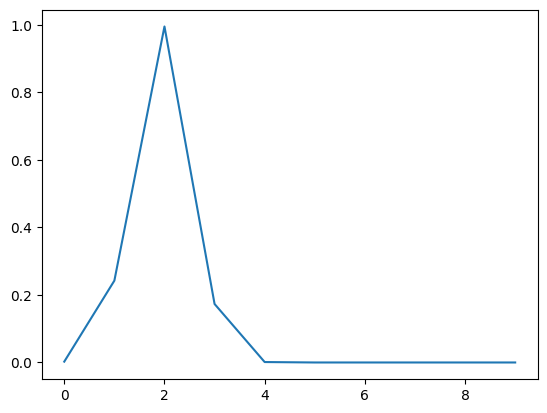

In [7]:
%matplotlib inline
plt.plot(tuning_curves[0])

In [7]:
def get_X(
    sigma=10,
    rho=28,
    beta=8 / 3,
    duration=2000,
    dt=0.01,
    initial_state=[0, 5, 0],
    n_units_p=20,
):
    # Time points
    t = np.arange(0, duration, dt)

    # Simulate the Lorenz system
    X_raw = preprocess_X(simulate_lorenz(t, initial_state, sigma, rho, beta))

    X = np.array([generate_tuning_curves(X_raw[:, i], n_units_p) for i in range(3)])
    return X_raw, np.transpose(X, (1, 0, 2))

In [9]:
X_raw, X = get_X(duration=20000)

In [33]:
def nonlinearity(x, scale=8, offset=0.6):
    return 1 / (1 + torch.exp(-scale * (x - offset)))

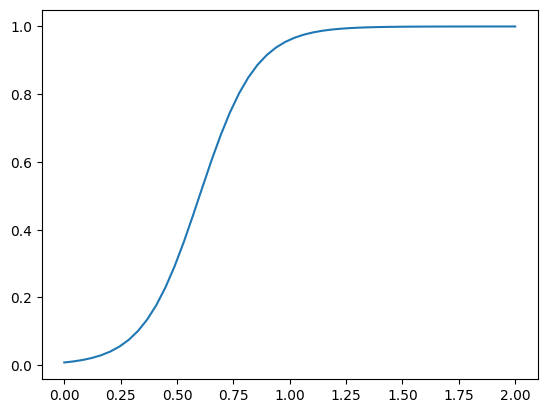

In [34]:
%matplotlib inline
plt.figure()
x = np.linspace(0, 2, 50)
plt.plot(x, nonlinearity(torch.tensor(x)).numpy())

In [10]:
def f_homeostasis(mean_activity, threshold_offset=0.0):
    return max(mean_activity + threshold_offset, 0)

In [11]:
from matplotlib.animation import FuncAnimation


def animate_scatter_and_line(positions, trajectory):
    T, _, N = positions.shape
    M, _ = trajectory.shape

    # Create a figure and 3D axis for the scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    scatter = ax.scatter([], [], [], c="b", marker="o")
    (line,) = ax.plot(
        [], [], [], c="r", linewidth=0.5, alpha=0.5
    )  # Static line trajectory

    # Set axis limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)

    # Update function for animation
    def update(frame):
        x = positions[frame, 0, :]
        y = positions[frame, 1, :]
        z = positions[frame, 2, :]
        scatter._offsets3d = (x, y, z)

        line.set_data(trajectory[:, 0], trajectory[:, 1])
        line.set_3d_properties(trajectory[:, 2])

        return scatter, line

    # Create the animation
    ani = FuncAnimation(fig, update, frames=T, blit=True, interval=5)
    return fig, ani

In [12]:
def simulate(
    X,
    lmbda1=1,
    lmbda2=1e2,
    n_units=N_UNITS,
    dt=DT,
    alpha=300,
    beta_in=5e-3,
    gamma1=1,
    gamma2=3e2,
    target_activity=4/N_UNITS,
    w=None,
):
    device = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    )  # Use GPU if available

    n_steps, n_features, n_units_p = X.shape

    # w = 1 * np.random.randn(n_units, n_features, n_units_p)
    # w -= w.mean()
    if w is None:
        w = np.random.uniform(0, 0.2, size=(n_units, n_features, n_units_p))  # + 0.1

    V = torch.zeros((n_steps, n_units), device=device)
    X = torch.from_numpy(X).to(device)
    w = torch.from_numpy(w).to(device)
    slow_a = target_activity * torch.ones(n_units, device=device)
    fast_a = target_activity * torch.ones(n_units, device=device)

    W = []
    W_mean_hist = []
    W_var_hist = []
    DW_max = []
    Slow_A = []
    Fast_A = []

    for t in range(-300, 0):
        dv = (
            (
                -lmbda1 * V[t - 1]
                + nonlinearity(
                    torch.einsum("kij,ij->k", w, X[t])
                    - lmbda2
                    * f_homeostasis(fast_a.mean(), threshold_offset=-target_activity)
                )
            )
            * dt
            * alpha
        )

        V[t] = V[t - 1] + dv
        slow_a += (V[t] - slow_a) * dt * gamma1
        fast_a += (V[t] - fast_a) * dt * gamma2

    for t in range(n_steps):
        dv = (
            (
                -lmbda1 * V[t - 1]
                + nonlinearity(
                    torch.einsum("kij,ij->k", w, X[t])
                    - lmbda2
                    * f_homeostasis(fast_a.mean(), threshold_offset=-target_activity)
                )
            )
            * dt
            * alpha
        )

        V[t] = V[t - 1] + dv

        dw = (
            (
                -50 * (
                    (w / w.mean((1, 2))[:, None, None])
                    * torch.maximum(
                        slow_a - target_activity, torch.zeros(n_units, device=device)
                    )[:, np.newaxis, np.newaxis]
                )
                + 70
                * torch.einsum(
                    "kij,k->kij",
                    (X[None, t] - w),
                    torch.maximum(
                        (target_activity - fast_a), torch.zeros(n_units, device=device)
                    )
                    * torch.maximum(
                        (target_activity - slow_a), torch.zeros(n_units, device=device)
                    ),
                )
                + torch.einsum("ij,k->kij", X[t], dv / dt)
                - 1 * w * (dv / dt)[:, np.newaxis, np.newaxis]
                - 3 * w**3
            )
            * dt
            * beta_in
        )

        w += dw
        w = torch.relu(w)
        slow_a += (V[t] - slow_a) * dt * gamma1
        fast_a += (V[t] - fast_a) * dt * gamma2

        # multiplicative / competetive normalization
        # w = 0.99 * w + 0.01 * (w / w.mean((1, 2))[:, np.newaxis, np.newaxis])

        if t % 5000 == 0:
            W.append(w.cpu().numpy())

        DW_max.append(dw.abs().max().cpu().item())
        Slow_A.append(slow_a.mean().cpu().item())
        Fast_A.append(fast_a.mean().cpu().item())

    return (
        V.cpu().numpy(),
        w.cpu().numpy(),
        W,
        slow_a.cpu().numpy(),
        DW_max,
        Slow_A,
        Fast_A,
    )

In [ ]:
V, w_new, W, a, DW_max, Slow_A, Fast_A = simulate(X[:], n_units=200)#, w=w.copy())

In [13]:
import os

X = np.load("checkpoints/kmeans/X.npy")
X_raw = np.load("checkpoints/kmeans/X_raw.npy")
w_new = np.load("checkpoints/kmeans/w.npy")
W = np.load("checkpoints/kmeans/W.npy")
V = np.load("checkpoints/kmeans/V.npy")

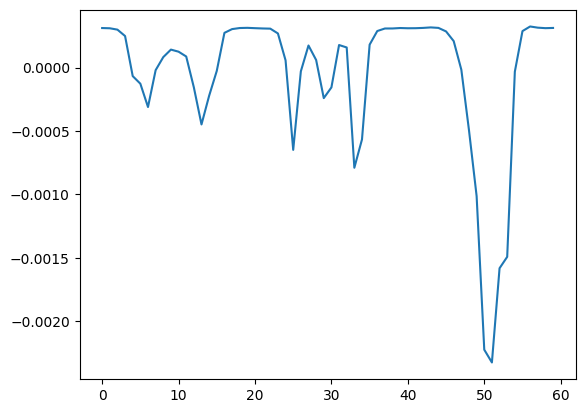

In [15]:
%matplotlib inline
plt.figure()
plt.plot(((0.07 - w_new) ** 3).mean((0)).flatten())

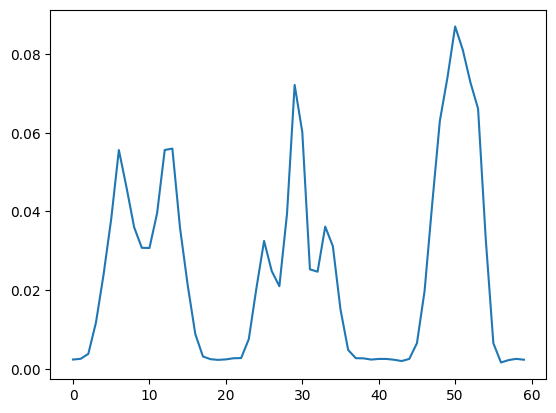

In [16]:
%matplotlib inline
plt.figure()
plt.plot(w_new.mean(0).flatten())

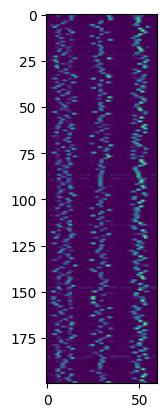

In [17]:
%matplotlib inline
plt.figure()
plt.imshow(w_new.reshape(-1, 60))

In [18]:
offset = 90000
V[offset - 2000 : offset].mean(0).round(3)

array([0.006, 0.005, 0.007, 0.006, 0.007, 0.007, 0.007, 0.006, 0.007,
       0.005, 0.005, 0.008, 0.007, 0.007, 0.007, 0.007, 0.007, 0.008,
       0.008, 0.006, 0.006, 0.007, 0.002, 0.007, 0.007, 0.007, 0.007,
       0.008, 0.006, 0.006, 0.007, 0.005, 0.006, 0.007, 0.006, 0.007,
       0.007, 0.007, 0.008, 0.007, 0.007, 0.008, 0.006, 0.007, 0.007,
       0.006, 0.007, 0.007, 0.006, 0.005, 0.007, 0.006, 0.009, 0.007,
       0.009, 0.007, 0.008, 0.007, 0.006, 0.008, 0.007, 0.007, 0.006,
       0.006, 0.005, 0.005, 0.006, 0.007, 0.007, 0.007, 0.005, 0.007,
       0.008, 0.006, 0.006, 0.006, 0.007, 0.007, 0.004, 0.007, 0.007,
       0.006, 0.007, 0.006, 0.006, 0.007, 0.008, 0.007, 0.007, 0.007,
       0.007, 0.005, 0.006, 0.007, 0.007, 0.008, 0.007, 0.007, 0.007,
       0.005, 0.007, 0.008, 0.004, 0.005, 0.006, 0.006, 0.007, 0.006,
       0.007, 0.007, 0.007, 0.007, 0.008, 0.007, 0.007, 0.006, 0.007,
       0.008, 0.007, 0.006, 0.007, 0.007, 0.007, 0.007, 0.008, 0.007,
       0.005, 0.007,

In [19]:
V[-100:].max()

0.40073243

In [20]:
V[-1].round(3)

array([0.041, 0.   , 0.   , 0.001, 0.   , 0.   , 0.   , 0.   , 0.001,
       0.029, 0.014, 0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.001, 0.001, 0.002, 0.   , 0.001, 0.001, 0.003, 0.001, 0.015,
       0.001, 0.005, 0.01 , 0.   , 0.   , 0.   , 0.003, 0.004, 0.   ,
       0.001, 0.003, 0.   , 0.006, 0.   , 0.   , 0.009, 0.   , 0.   ,
       0.001, 0.011, 0.003, 0.002, 0.   , 0.   , 0.001, 0.001, 0.001,
       0.003, 0.   , 0.006, 0.   , 0.001, 0.   , 0.054, 0.024, 0.029,
       0.   , 0.005, 0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.001,
       0.004, 0.009, 0.   , 0.001, 0.   , 0.002, 0.   , 0.003, 0.006,
       0.117, 0.004, 0.   , 0.   , 0.   , 0.   , 0.002, 0.   , 0.005,
       0.019, 0.008, 0.001, 0.055, 0.033, 0.   , 0.   , 0.029, 0.006,
       0.   , 0.   , 0.051, 0.001, 0.   , 0.004, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.001, 0.001, 0.055, 0.   , 0.   ,
       0.03 , 0.   , 0.   , 0.094, 0.008, 0.   , 0.001, 0.   , 0.   ,
       0.007, 0.001,

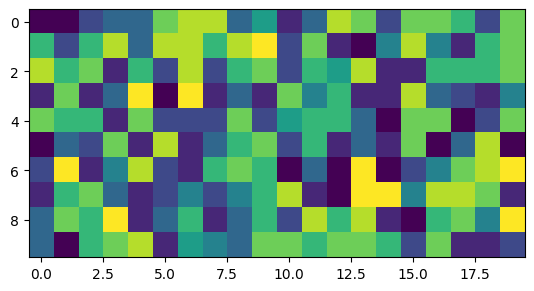

In [21]:
%matplotlib inline
plt.figure()
plt.imshow(V[-2000:].mean(0).round(3).reshape(10, 20))

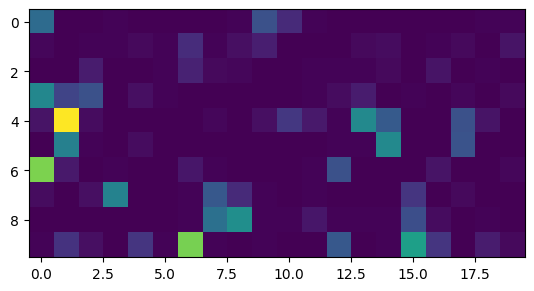

In [22]:
%matplotlib inline
plt.figure()
plt.imshow(V[-1].round(3).reshape(10, 20))

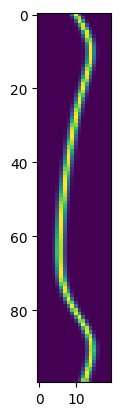

In [23]:
%matplotlib inline
plt.figure()
plt.imshow(X[-100:, 2])

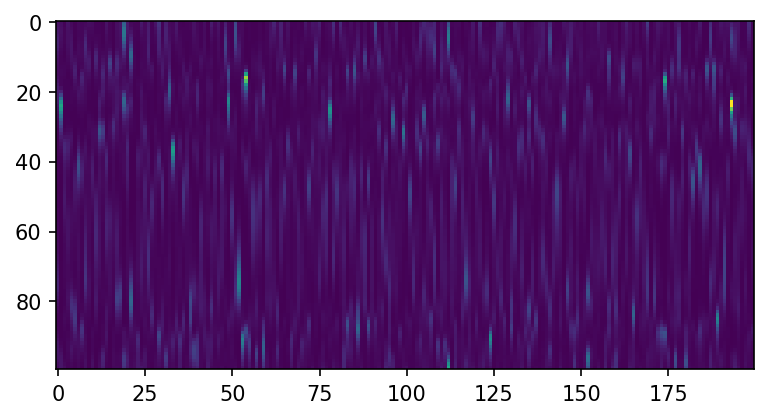

In [24]:
%matplotlib inline
plt.figure(figsize=(6, 6), dpi=150)
offset = 100000
plt.imshow(V[offset : offset + 100])

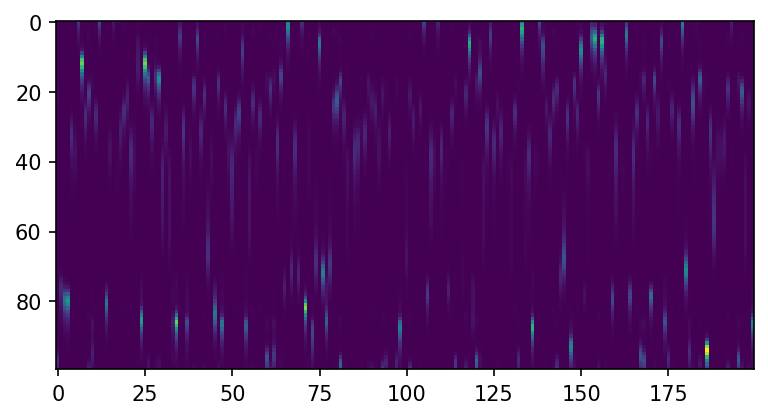

In [25]:
%matplotlib inline
plt.figure(figsize=(6, 6), dpi=150)
plt.imshow(V[-100:])

In [26]:
n_steps, n_features, n_units_p = X.shape

unit_locations_history = np.array(
    [
        [estimate_scalars_from_tuning_curves(w[:, i]) for i in range(n_features)]
        for w in W
    ]
)

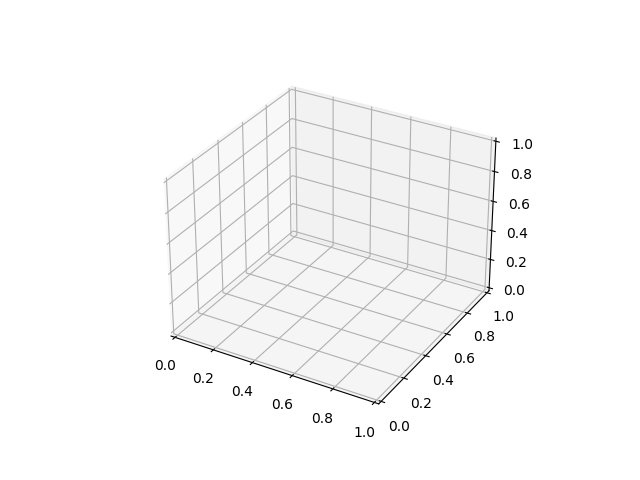

In [27]:
%matplotlib widget
fig, ani = animate_scatter_and_line(unit_locations_history, X_raw[:10000])

In [28]:
plt.close(fig)

In [108]:
W = np.array(W)

In [111]:
DW = W[1:] - W[:-1]

In [132]:
np.abs(DW).mean((2, 3)).argmax(keepdims=False)

488458

In [136]:
DW.shape

(4999, 200, 3, 20)

In [145]:
A = DW.max((2, 3))

In [146]:
np.unravel_index(np.abs(A).argmax(), A.shape)

(1810, 66)

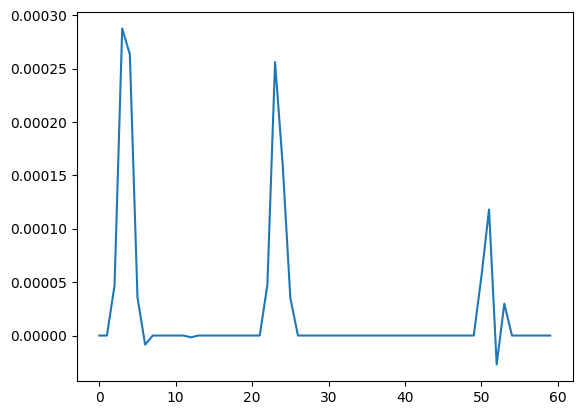

In [147]:
%matplotlib inline
plt.figure()
plt.plot(DW[3854, 58].flatten())

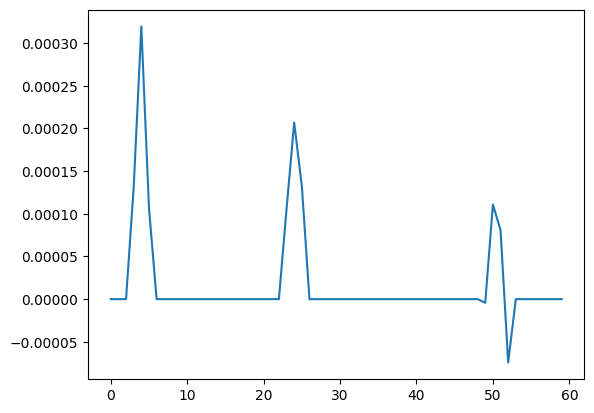

In [148]:
%matplotlib inline
plt.figure()
plt.plot(DW[1810, 66].flatten())

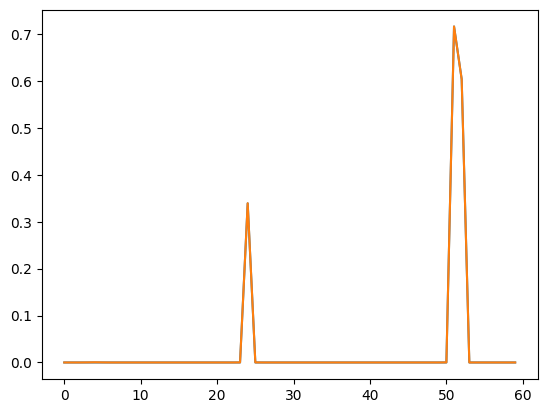

In [150]:
%matplotlib inline
plt.figure()
plt.plot(W[1808, 66].flatten())
plt.plot(W[1811, 66].flatten())

In [170]:
DL = unit_locations_history[1:] - unit_locations_history[:-1]

In [171]:
np.unravel_index(np.abs(DL).argmax(), DL.shape)

(27, 1, 40)

In [172]:
unit_locations_history[27, 1, 40]

1.013157791626816

In [175]:
unit_locations_history.shape

(5000, 3, 200)

In [176]:
W[2, 66, 0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.67650503e-06, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [173]:
DL[2, 0, 66]

-0.8078946530341712

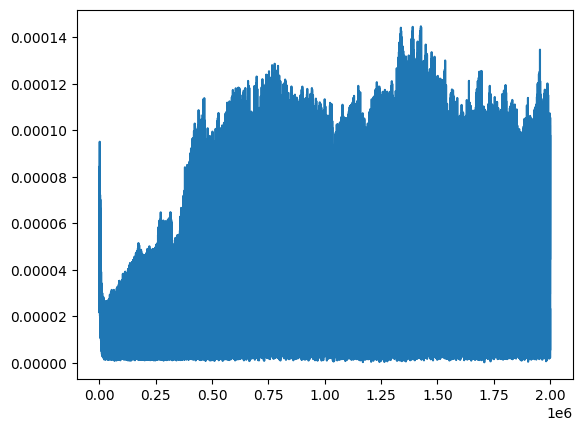

In [62]:
%matplotlib inline
plt.figure()
plt.plot(DW_max[100:])

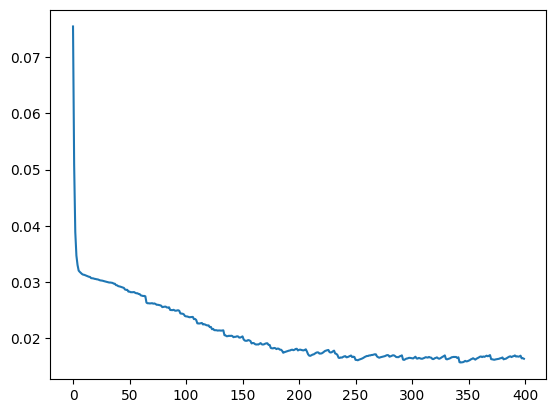

In [63]:
%matplotlib inline
plt.figure()
plt.plot(np.array(W).mean((1, 2, 3)))

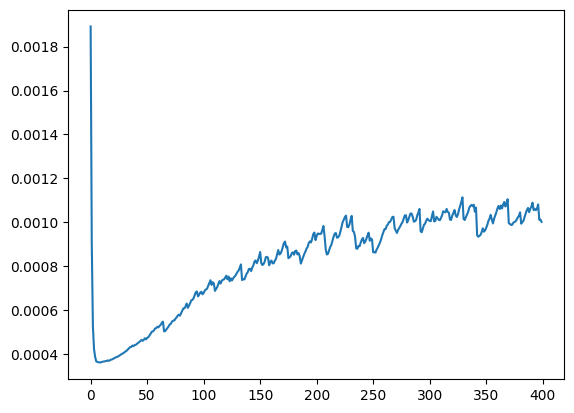

In [64]:
%matplotlib inline
plt.plot(np.array(W).var((1, 2, 3)))

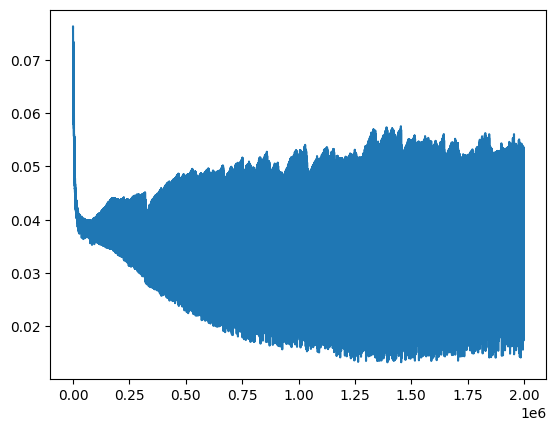

In [65]:
%matplotlib inline
plt.plot(V.mean(1)[400:])

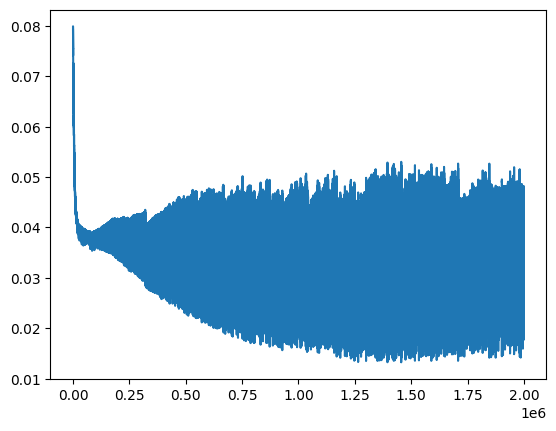

In [66]:
%matplotlib inline
plt.plot(Fast_A[:])

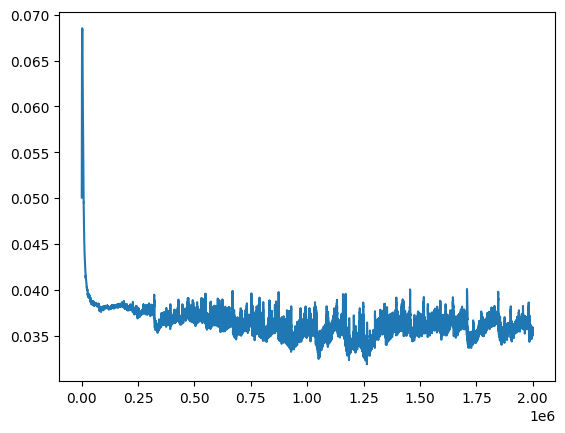

In [67]:
%matplotlib inline
plt.plot(Slow_A[:])

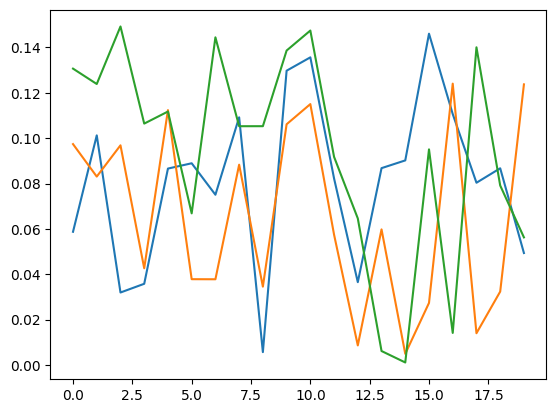

In [68]:
%matplotlib inline
plt.figure()
plt.plot(W[0][1].T)

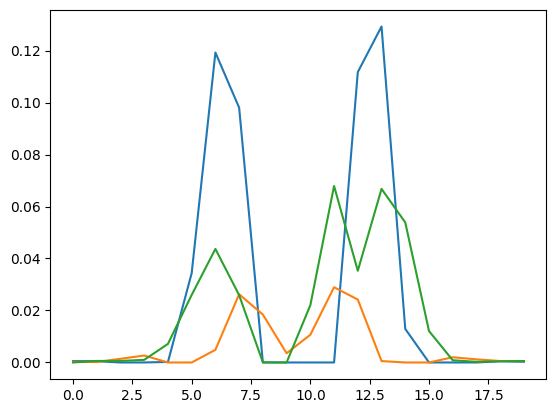

In [75]:
%matplotlib inline
plt.figure()
plt.plot(W[-1][5].T)

(array([33., 41., 55., 44., 17.,  5.,  3.,  1.,  0.,  1.]),
 array([0.02086372, 0.02403723, 0.02721074, 0.03038425, 0.03355777,
        0.03673128, 0.03990479, 0.0430783 , 0.04625181, 0.04942533,
        0.05259884]),
 <BarContainer object of 10 artists>)

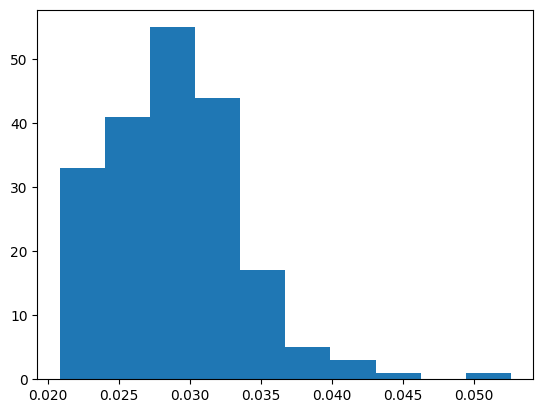

In [54]:
%matplotlib inline
plt.hist(w_new.mean((1, 2)))

(array([10., 30., 23., 22., 20., 22., 30., 17., 18.,  8.]),
 array([0.00439173, 0.01109394, 0.01779615, 0.02449836, 0.03120057,
        0.03790278, 0.04460499, 0.05130719, 0.0580094 , 0.06471162,
        0.07141382]),
 <BarContainer object of 10 artists>)

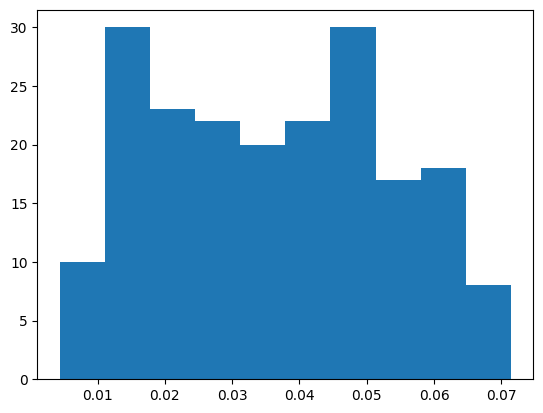

In [55]:
plt.hist(V[-1000:].mean(0))

In [ ]:
import os

if not os.path.exists("checkpoints/kmeans"):
    os.makedirs("checkpoints/kmeans")

np.save("checkpoints/kmeans/X.npy", X)
np.save("checkpoints/kmeans/X_raw.npy", X_raw)
np.save("checkpoints/kmeans/w.npy", w_new)
np.save("checkpoints/kmeans/W.npy", W)
np.save("checkpoints/kmeans/V.npy", V)

In [217]:
%matplotlib inline
plt.hist(
    nonlinearity(
        torch.einsum("kij,ij->k", torch.tensor(w), torch.tensor(X[-1]))
        - 8 * f_lateral_inhibition(V[-1 - 1].mean())
    )
)

NameError: name 'f_lateral_inhibition' is not defined

(array([11571668.,   544452.,   357066.,   284386.,   252265.,   242220.,
          246525.,   275304.,   352339.,   873775.]),
 array([0.18242552, 0.24594042, 0.30945531, 0.37297021, 0.4364851 ,
        0.5       , 0.5635149 , 0.62702979, 0.69054469, 0.75405958,
        0.81757448]),
 <BarContainer object of 10 artists>)

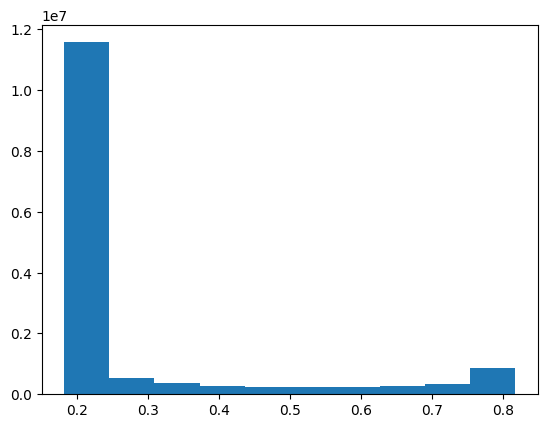

In [161]:
%matplotlib inline
plt.hist(nonlinearity(torch.tensor(X).flatten()).cpu().numpy())

In [ ]:
w.shape

In [ ]:
w_prime = w / w.sum(2)[:, :, np.newaxis]

In [ ]:
plt.plot(w[99, 2])

In [ ]:
plt.plot(w_prime[:3, 2].T)

In [ ]:
plt.plot(tuning_curves[:4].T);

In [ ]:
unit_locations_history.shape

In [241]:
unit_locations = np.array(
    [estimate_scalars_from_tuning_curves(w[:, i]) for i in range(n_features)]
)

In [242]:
unit_locations.max()

1.2166318837117882

In [251]:
unit_locations.shape

(3, 100)

In [243]:
unit_locations.min()

-0.2896282954398167

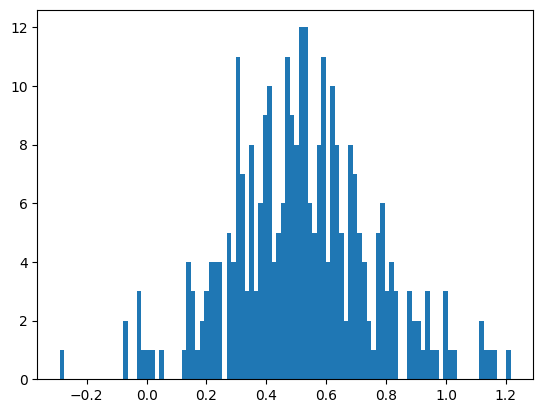

In [244]:
plt.hist(unit_locations.flatten(), bins=100);  # plt.xlim(-5, 6)